# ENet方式分割脑图像

## 一、加载数据

先导入需要的包

In [6]:
# 导入需要的包
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image,ImageOps
from mxtorch import transforms as tfs
from datetime import datetime
import random

import matplotlib.pyplot as plt
%matplotlib inline

----

In [7]:
M_root = './M'#数据根目录

def read_images(root=M_root, train=True):
    txt_fname = root + '/sets/' + ('train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, 'images', i+'.bmp') for i in images]
    label = [os.path.join(root, 'class', i+'.bmp') for i in images]
    return data, label

---

In [8]:
def randomRotation(data, label, degree,mode=Image.BICUBIC):
  
        """
         对图像进行随机任意角度(0~360度)旋转
        :param mode 邻近插值,双线性插值,双三次B样条插值(default)
        :param image PIL的图像image
        :return: 旋转转之后的图像
        """
        random_angle = np.random.randint(1, degree)
        return data.rotate(random_angle, mode) , label.rotate(random_angle, Image.NEAREST)

In [9]:
def random_crop(data, label, crop_size):
    height, width = crop_size
    data, rect = tfs.RandomCrop((height, width))(data)
    label = tfs.FixedCrop(*rect)(label)
    return data, label

----

In [10]:
classes = ['background','CSF','GM','WM']

# RGB color for each class
colormap = [[0,0,0],[85,85,85],[170,170,170], [255,255,255]]

len(classes), len(colormap)

(4, 4)

In [11]:
cm2lbl = np.zeros(256**3) # 每个像素点有 0 ~ 255 的选择，RGB 三个通道
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i # 建立索引

def image2label(img):
    data = np.array(img, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64') # 根据索引得到 label 矩阵

In [12]:
def img_transforms(img,label, crop_size,degree):#,center_crop_size
    
    #img, label = random_horizontally_flip()(img, label)
    img, label = randomRotation(img, label,degree)
    #img, label = center_crop(img, label, center_crop_size)
    img, label = random_crop(img, label, crop_size)
    
    img_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = img_tfs(img)
    label = image2label(label)
    label = torch.from_numpy(label)
    return img, label

In [13]:
class MRSegDataset(Dataset):
    '''
    mr dataset
    '''
    def __init__(self, train,crop_size,degree,transforms):# center_crop_size,
        #self.center_crop_size = center_crop_size
        self.crop_size = crop_size
        self.degree = degree
        self.transforms = transforms
        data_list, label_list = read_images(train=train)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        print('Read ' + str(len(self.data_list)) + ' images')
        
    def _filter(self, images): # 过滤掉图片大小小于 crop 大小的图片
        return [im for im in images if (Image.open(im).size[1] >= self.crop_size[0] and 
                                        Image.open(im).size[0] >= self.crop_size[1])]
        
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.transforms(img, label,self.crop_size, self.degree)# self.center_crop_size, 
        return img, label
    
    def __len__(self):
        return len(self.data_list)

In [14]:
# 实例化数据集
#center_crop_size = 270
crop_size = (200,200)
traindegree = 180
input_shape = (384, 384)
testdegree = 2

mr_train = MRSegDataset(True, crop_size, traindegree,img_transforms)
mr_test = MRSegDataset(False, input_shape,testdegree, img_transforms)

train_data = DataLoader(mr_train, 16, shuffle=True, num_workers=2)
valid_data = DataLoader(mr_test, 8, num_workers=2)

Read 256 images
Read 48 images


---
## 二、构造模型

E-Net

定义ENet中的初始化模块

In [15]:
class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.
    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 padding=0,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=kernel_size,
            stride=2,
            padding=padding,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(kernel_size, stride=2, padding=padding)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_prelu = activation

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_prelu(out)

定义常规瓶颈层

In [16]:
class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.
    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation,
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation)
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_prelu = activation

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_prelu(out)

定义下采样瓶颈层

In [17]:
class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.
    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.
    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension branch.
    Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    - asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            kernel_size,
            stride=2,
            padding=padding,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_prelu = activation

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = Variable(torch.zeros(n, ch_ext - ch_main, h, w))

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_prelu(out), max_indices

定义上采样瓶颈层

In [18]:
class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.
    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.
    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in the
    convolution layer described above in item 2 of the extension branch.
    Default: 3.
    - padding (int, optional): zero-padding added to both sides of the input.
    Default: 0.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation)

        # Transposed convolution
        self.ext_conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=2,
                padding=padding,
                output_padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_prelu = activation

    def forward(self, x, max_indices):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(main, max_indices)
        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_prelu(out)

ENet主体

In [19]:
class ENet(nn.Module):
    """Generate the ENet model.
    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.
    """

    def __init__(self, num_classes, encoder_relu=False, decoder_relu=True):
        super().__init__()

        self.initial_block = InitialBlock(3, 16, padding=1, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            padding=1,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            padding=1,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
            bias=False)

    def forward(self, x):
        # Initial block
        x = self.initial_block(x)

        # Stage 1 - Encoder
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0)
        x = self.regular5_1(x)
        x = self.transposed_conv(x)

        return x

In [20]:
num_classes = len(classes)

In [21]:
net = ENet(num_classes)
net = net.cuda()

多GPU处理(可选)

In [22]:
net=nn.DataParallel(net,device_ids=[0,1])

加载预训练权重

In [17]:
net.load_state_dict(torch.load('.pth'))

## 开始训练

In [23]:
from mxtorch.vision.eval_tools import eval_semantic_segmentation

In [24]:
# 定义 loss 和 optimizer
from mxtorch.trainer import ScheduledOptim
criterion = nn.NLLLoss2d()
#basic_optim = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)
basic_optim = torch.optim.Adam(net.parameters(), lr=5e-4)
optimizer = ScheduledOptim(basic_optim)

/home/ql/.conda/envs/QL/lib/python3.6/site-packages/torch/nn/modules/loss.py:198: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see http://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [25]:
for e in range(100):
    if e > 0 and e % 100 == 0:
        optimizer.set_learning_rate(optimizer.learning_rate * 0.1)
    train_loss = 0
    train_acc = 0
    train_mean_iu = 0
    train_mean_dice = 0
    
    prev_time = datetime.now()
    net = net.train()
    for data in train_data:
        im = Variable(data[0].cuda())
        labels = Variable(data[1].cuda())
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        loss = criterion(out, labels)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)
        
        train_acc += eval_metrics['mean_class_accuracy']
        train_mean_iu += eval_metrics['miou']
        train_mean_dice += eval_metrics['mdice']
        
    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_mean_iu = 0
    eval_mean_dice = 0
    
    for data in valid_data:
        im = Variable(data[0].cuda(), volatile=True)
        labels = Variable(data[1].cuda(), volatile=True)
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, labels)
        eval_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)

    eval_acc += eval_metrics['mean_class_accuracy']
    eval_mean_iu += eval_metrics['miou']
    eval_mean_dice += eval_metrics['mdice']
    
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, Train Mean dice: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f},valid Mean dice: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(train_data), train_mean_iu / len(train_data), train_mean_dice / len(train_data),
        eval_loss / len(valid_data), eval_acc, eval_mean_iu,eval_mean_dice))
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str + ' lr: {}'.format(optimizer.learning_rate))

/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Train Loss: 1.34949, Train Acc: 0.28526, Train Mean IU: 0.14754, Train Mean dice: 0.23639, Valid Loss: 1.36120, Valid Acc: 0.23715, Valid Mean IU: 0.15462,valid Mean dice: 0.20779 Time: 0:0:7 lr: 0.0005
Epoch: 1, Train Loss: 1.18664, Train Acc: 0.36549, Train Mean IU: 0.25128, Train Mean dice: 0.34563, Valid Loss: 1.21937, Valid Acc: 0.25283, Valid Mean IU: 0.23011,valid Mean dice: 0.25056 Time: 0:0:5 lr: 0.0005
Epoch: 2, Train Loss: 1.00574, Train Acc: 0.39956, Train Mean IU: 0.31265, Train Mean dice: 0.40012, Valid Loss: 0.92339, Valid Acc: 0.31707, Valid Mean IU: 0.29132,valid Mean dice: 0.34219 Time: 0:0:5 lr: 0.0005
Epoch: 3, Train Loss: 0.83587, Train Acc: 0.46816, Train Mean IU: 0.37013, Train Mean dice: 0.45021, Valid Loss: 0.64878, Valid Acc: 0.49605, Valid Mean IU: 0.37331,valid Mean dice: 0.44406 Time: 0:0:5 lr: 0.0005
Epoch: 4, Train Loss: 0.70427, Train Acc: 0.48189, Train Mean IU: 0.37392, Train Mean dice: 0.44359, Valid Loss: 0.51776, Valid Acc: 0.50500, Valid 

In [38]:
torch.save(net.state_dict(), 'ENet_params(0.90,augument).pth')

In [26]:
# net.load_state_dict(torch.load('./fcn.pth'))
net = net.eval()

In [27]:
classes = ['background','CSF','GM','WM']

# RGB color for each class
colormap_new = [[10,10,10],[240,255,240],[16,78,139], [205,133,63]]

len(classes), len(colormap)

(4, 4)

In [28]:
# 定义预测函数
cm = np.array(colormap_new).astype('uint8')

def predict(img, label): # 预测结果
    img = Variable(img.unsqueeze(0)).cuda()
    out = net(img)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]

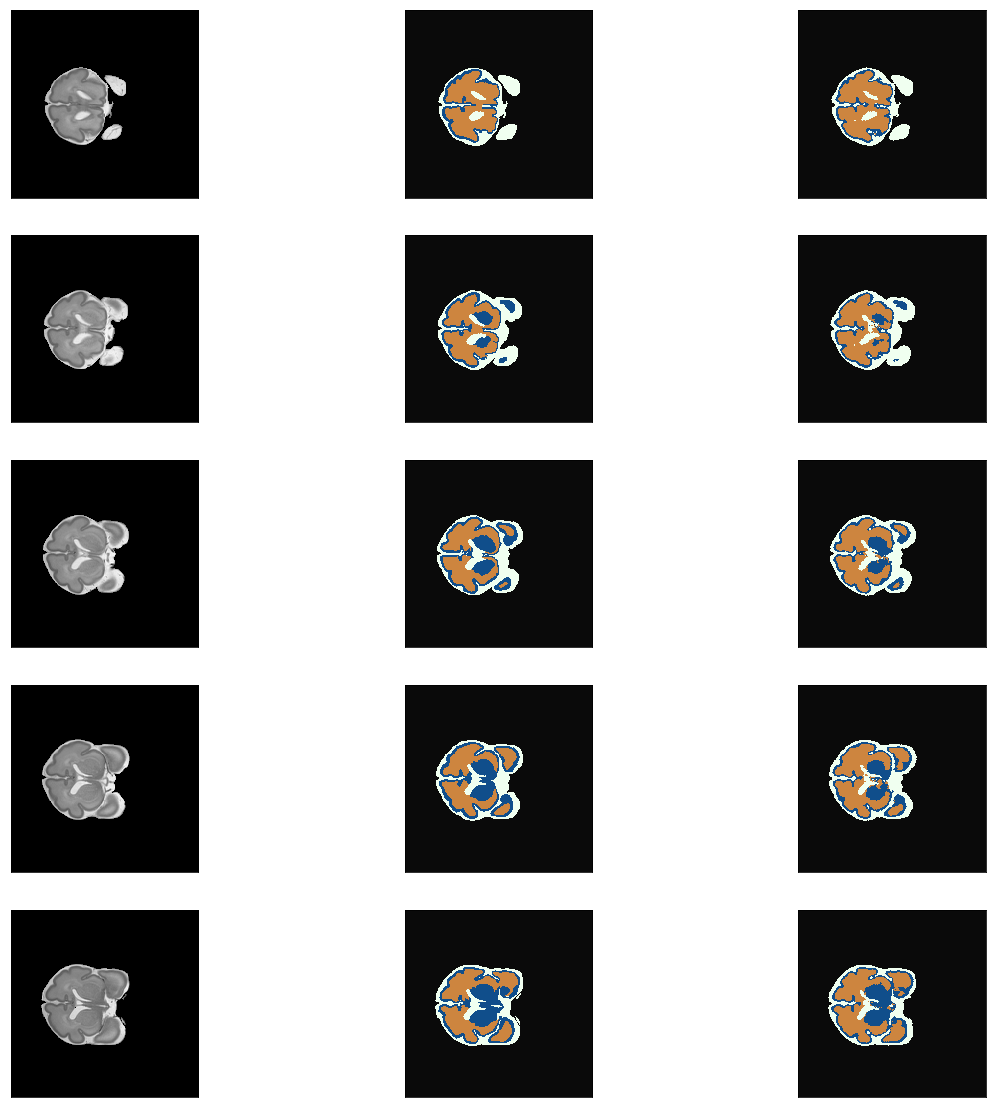

In [32]:
_, figs = plt.subplots(5, 3, figsize=(20, 20))
N = 12

for i in range(5):
    test_data, test_label = mr_test[i+N]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(mr_test.data_list[i+N]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)
    '''
    new_im = Image.fromarray(pred.astype(np.uint8))
    new_im.save('./pred'+np.str(i)+'.bmp')
    label_im = Image.fromarray(label.astype(np.uint8))
    label_im.save('./label'+np.str(i)+'.bmp')
    img = Image.open(mr_test.data_list[i+N])
    img.save('./img'+np.str(i)+'.bmp')
    '''

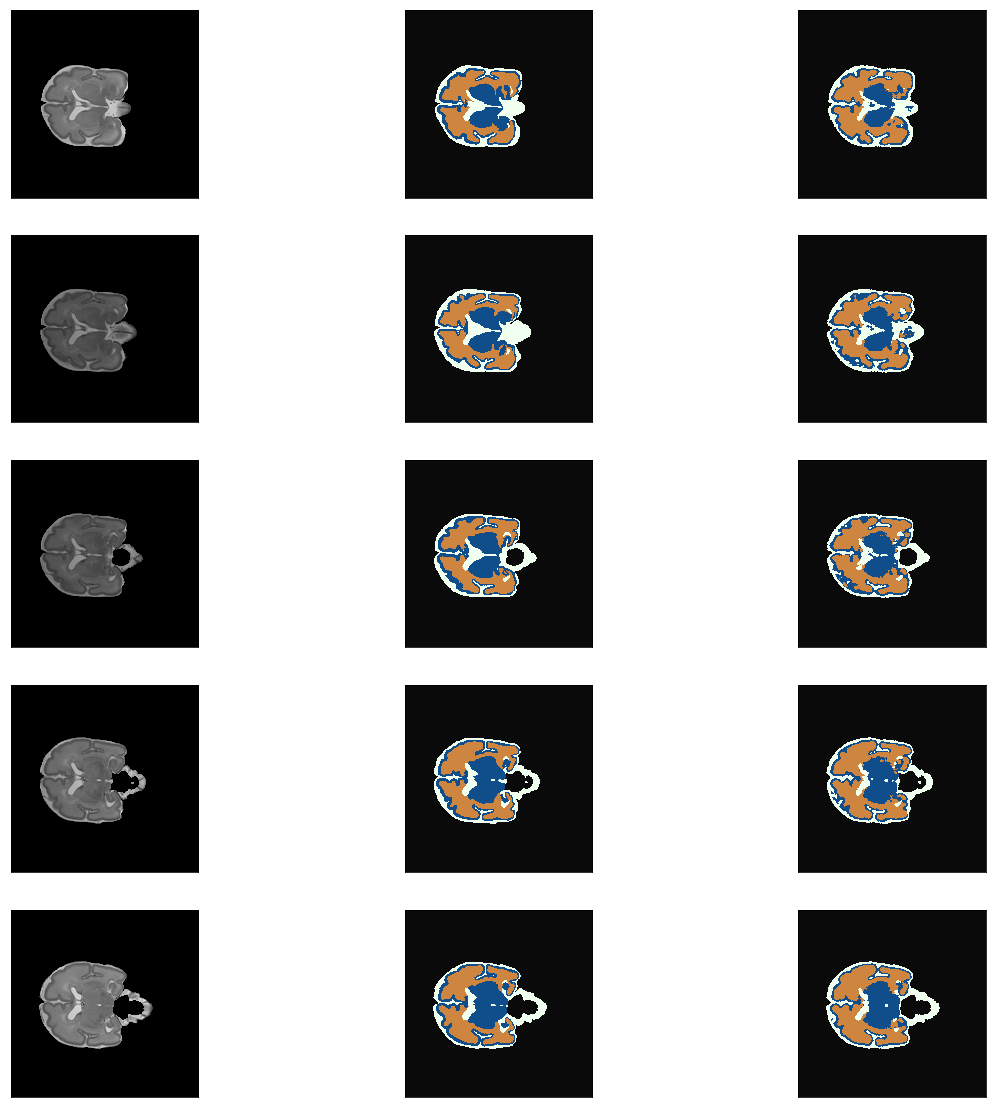

In [33]:
_, figs = plt.subplots(5, 3, figsize=(20, 20))
N = 17

for i in range(5):
    test_data, test_label = mr_test[i+N]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(mr_test.data_list[i+N]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)
    '''
    new_im = Image.fromarray(pred.astype(np.uint8))
    new_im.save('./pred'+np.str(i)+'.bmp')
    label_im = Image.fromarray(label.astype(np.uint8))
    label_im.save('./label'+np.str(i)+'.bmp')
    img = Image.open(mr_test.data_list[i+N])
    img.save('./img'+np.str(i)+'.bmp')
    '''

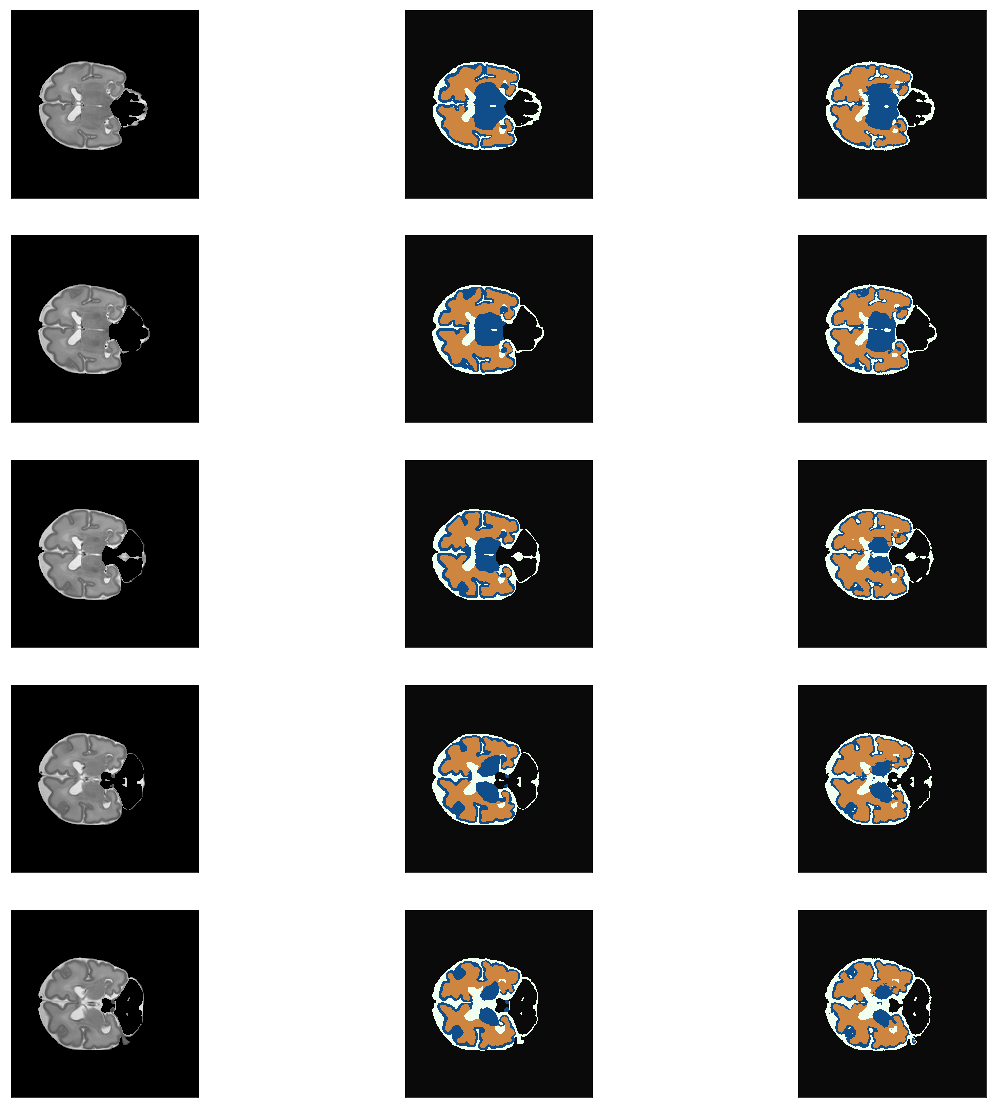

In [34]:
_, figs = plt.subplots(5, 3, figsize=(20, 20))
N = 22

for i in range(5):
    test_data, test_label = mr_test[i+N]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(mr_test.data_list[i+N]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)
    '''
    new_im = Image.fromarray(pred.astype(np.uint8))
    new_im.save('./pred'+np.str(i)+'.bmp')
    label_im = Image.fromarray(label.astype(np.uint8))
    label_im.save('./label'+np.str(i)+'.bmp')
    img = Image.open(mr_test.data_list[i+N])
    img.save('./img'+np.str(i)+'.bmp')
    '''

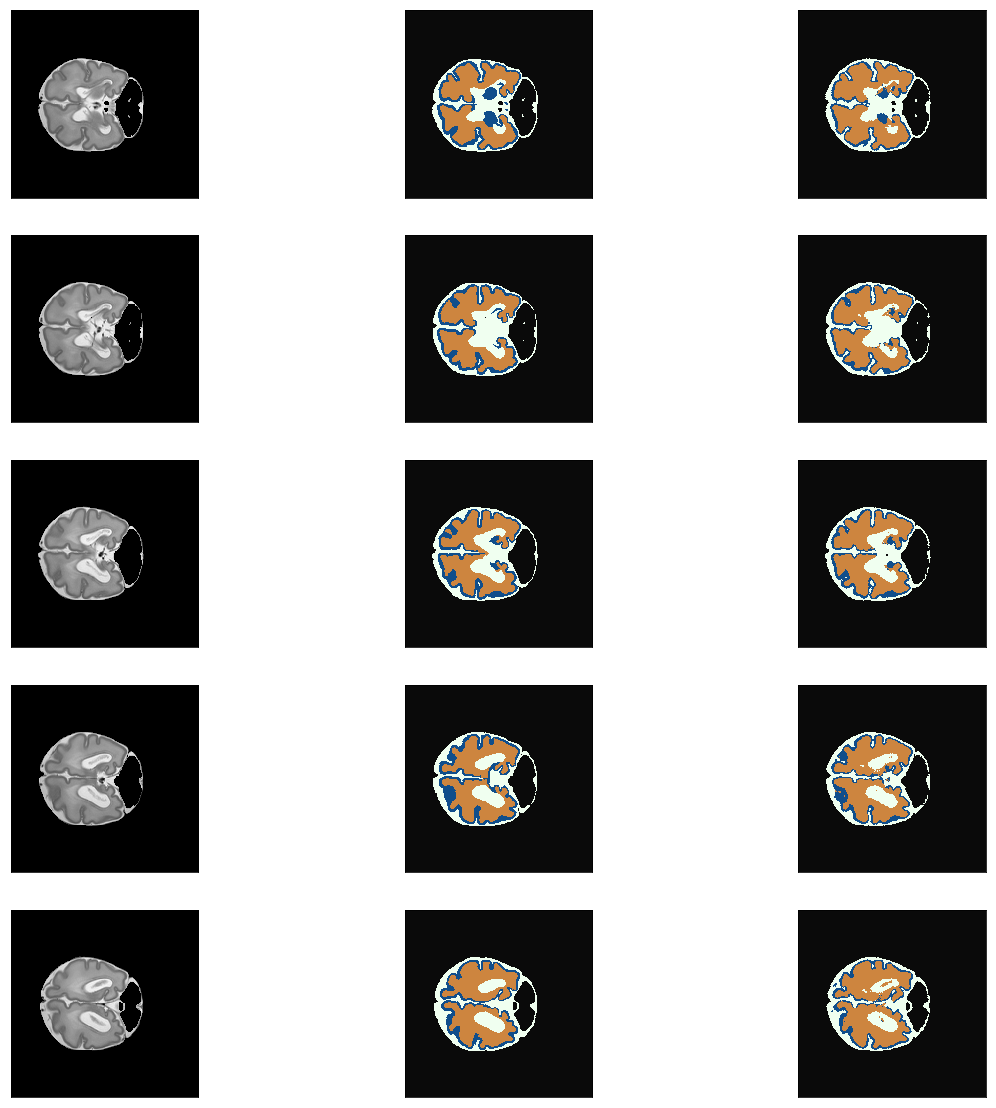

In [35]:
_, figs = plt.subplots(5, 3, figsize=(20, 20))
N = 27

for i in range(5):
    test_data, test_label = mr_test[i+N]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(mr_test.data_list[i+N]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)
    '''
    new_im = Image.fromarray(pred.astype(np.uint8))
    new_im.save('./pred'+np.str(i)+'.bmp')
    label_im = Image.fromarray(label.astype(np.uint8))
    label_im.save('./label'+np.str(i)+'.bmp')
    img = Image.open(mr_test.data_list[i+N])
    img.save('./img'+np.str(i)+'.bmp')
    '''